# Collection and Cleaning of California Wildfire Data

---

What's the correlation between these wildfires and meteorilogical data? (avg temp, avg rainfall, co2 emissions). Plot average rainfall and average temperature linearly (x=time), using clusters of dots to show when fires occurred (the sizes representing acres burned).  

Training K-means clustering on latitude and longitude for locating hotspots. Potentially predicting future wildfires based on preceding meteorilogical data.
Training K-nearest neighbors on weather conditions to predict conditions that lead to fires.

In [22]:
county_ids = {
  'Tuolumne' : 'CA-109',
  'Los Angeles' : 'CA-037', 
  'Riverside' : 'CA-065', 
  'Placer' : 'CA-061', 
  'Ventura' : 'CA-111',
  'Fresno' : 'CA-019', 
  'Siskiyou' : 'CA-093', 
  'Humboldt' : 'CA-023',
  'Tehama' : 'CA-103', 
  'Shasta' : 'CA-089', 
  'San Diego' : 'CA-073',
  'Kern' : 'CA-029', 
  'Sonoma' : 'CA-097', 
  'Contra Costa' : 'CA-013', # added to SCU
  'Butte' : 'CA-007',
  'Tulare' : 'CA-107',
  'Santa Barbara' : 'CA-083', 
  'Mariposa' : 'CA-043', 
  'Monterey' : 'CA-053', 
  'El Dorado' : 'CA-017',
  'San Bernardino' : 'CA-071', 
  'Plumas' : 'CA-063', # PNF (Plumas National Forest)
  'Modoc' : 'CA-049', 
  'San Luis Obispo' : 'CA-079', 
  'Madera' : 'CA-039',
  'Inyo' : 'CA-027', # Inyo National Forest and Death Valley National Park (negligible)
  'Napa' : 'CA-055', 
  'San Benito' : 'CA-069', 
  'San Joaquin' : 'CA-077', # added to TCU
  'Lake' : 'CA-033', 
  'Alameda' : 'CA-001', # added to SCU
  'Glenn' : 'CA-021', 
  'Yolo' : 'CA-113', # added to LNU
  'Sacramento' : 'CA-067', # added to AEU
  'Stanislaus' : 'CA-099', # STF (Stanislaus National Forest)
  'Solano' : 'CA-095', # added to LNU
  'Merced' : 'CA-047',
  'Mendocino' : 'CA-045', 
  'Lassen' : 'CA-035', 
  'Amador' : 'CA-005', 
  'Yuba' : 'CA-115', 
  'Nevada' : 'CA-057', 
  'Santa Clara' : 'CA-085',
  'Calaveras' : 'CA-009', 
  'San Mateo' : 'CA-081', 
  'Orange' : 'CA-059', 
  'Colusa' : 'CA-011', # added to LNU
  'Trinity' : 'CA-105',
  'Del Norte' : 'CA-015', 
  'Mono' : 'CA-051', # Nothing exists here
  'Alpine' : 'CA-003', # Added to AEU
  'Sutter' : 'CA-101', # Added to NEU
  'Kings' : 'CA-031', 
  'Sierra' : 'CA-091', # Added to NEU
  'Santa Cruz' : 'CA-087', 
  'Marin' : 'CA-041', 
  'Mexico' : None, 
  'State of Oregon' : None,
  'State of Nevada' : None
}

In [23]:
unit_id_to_counties = {
  'AEU': ['Amador', 'El Dorado', 'Sacramento', 'Alpine'],
  'BDU': ['San Bernardino'],
  'BEU': ['San Benito', 'Monterey'],
  'BTU': ['Butte'],
  'CZU': ['San Mateo', 'Santa Cruz'], # south bay
  'FKU': ['Fresno', 'Kings'],
  'HUU': ['Humboldt', 'Del Norte'],
  'LMU': ['Lassen', 'Modoc'],
  'LNU': ['Sonoma', 'Lake', 'Napa', 'Yolo', 'Solano', 'Colusa'], # close fires
  'MEU': ['Mendocino'],
  'MMU': ['Madera', 'Mariposa', 'Merced'],
  'MVU': ['San Diego'],
  'NEU': ['Nevada', 'Yuba', 'Placer', 'Sutter', 'Sierra'],
  'RRU': ['Riverside'],
  'SCU': ['Santa Clara', 'Contra Costa', 'Alameda'], # east bay
  'SHU': ['Shasta', 'Trinity'],
  'SKU': ['Siskiyou'],
  'SLU': ['San Luis Obispo'],
  'TCU': ['Tuolumne', 'Calaveras', 'San Joaquin'],
  'TGU': ['Tehama', 'Glenn'],
  'TUU': ['Tulare'],
  'KRN': ['Kern'],
  'LAC': ['Los Angeles'],
  'MRN': ['Marin'],
  'ORC': ['Orange'],
  'SBC': ['Santa Barbara'],
  'VNC': ['Ventura'],
  'PNF': ['Plumas'],
  'STF': ['Stanislaus']
}

In [24]:
import pandas as pd
from altair import *
import requests
import time
import numpy as np
import copy

df_fire = pd.read_csv("ca_fires.csv")

df_fire = df_fire[df_fire["STATE"]=="CA"] # filter to CA only fires
df_fire["YEAR_"] = df_fire["YEAR_"].dropna().astype(int) # not working why?????
df_fire = df_fire.drop(df_fire[df_fire["YEAR_"]<=1900].index) # filter out everything before 1900
df_fire["ALARM_DATE"] = df_fire["ALARM_DATE"].map(lambda x: str(x)[:10])
df_fire["counties"] = df_fire["UNIT_ID"].map(unit_id_to_counties) # create county column

#df_fire["ALARM_DATE"] = pd.to_datetime(df_fire["ALARM_DATE"])

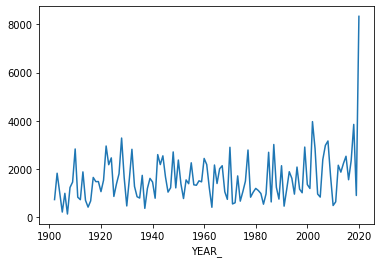

In [25]:
df_fire.groupby("YEAR_").mean()["GIS_ACRES"].plot.line()

In [26]:
def climate_data(county):
  # get precip
  resp = requests.get('https://www.ncdc.noaa.gov/cag/county/time-series/%s-pcp-12-12-1900-2022.json?base_prd=true&begbaseyear=1901&endbaseyear=2000' % county_ids[county])
  df_county_precip = pd.DataFrame(resp.json()["data"]).T
  df_county_precip = df_county_precip.rename(columns={"value" : "precip_value", "anomaly" : "precip_anomaly"})
  time.sleep(0.5)
  # get temp
  resp = requests.get('https://www.ncdc.noaa.gov/cag/county/time-series/%s-tavg-12-12-1900-2022.json?base_prd=true&begbaseyear=1901&endbaseyear=2000' % county_ids[county])
  df_county_temp = pd.DataFrame(resp.json()["data"]).T
  df_county_temp = df_county_temp.rename(columns={"value" : "temp_value", "anomaly" : "temp_anomaly"})
  df_county = pd.concat([df_county_temp, df_county_precip], axis=1)
  # cast values to numeric
  df_county["temp_value"] = df_county["temp_value"].astype(float)
  df_county["temp_anomaly"] = df_county["temp_anomaly"].astype(float)
  df_county["precip_value"] = df_county["precip_value"].astype(float)
  df_county["precip_anomaly"] = df_county["precip_anomaly"].astype(float)
  # indices to year
  df_county = df_county.reset_index().drop("index", axis=1)
  df_county.index = df_county.index + 1900
  return df_county

In [27]:
# combines county data, getting average between them 

def combine_counties(unit_id):
  # combine counties in unit_id
  counties = copy.deepcopy(unit_id_to_counties.get(unit_id))
  length = len(counties)
  df_climate = climate_data(counties[0])
  counties.pop(0)
  while counties != []:
    time.sleep(0.5)
    temp = climate_data(counties[0])
    counties.pop(0)
    df_climate = df_climate + temp
  df_climate = df_climate / length
  return df_climate

In [28]:
def combine_data(df_fire, unit_id):
  # get fire data
  df_fire = df_fire.drop(df_fire[df_fire["UNIT_ID"] != unit_id].index)
  frequency = df_fire["YEAR_"].value_counts().sort_index()
  acres_sum = df_fire.groupby("YEAR_").sum()["GIS_ACRES"].sort_index()
  acres_mean = df_fire.groupby("YEAR_").mean()["GIS_ACRES"].sort_index()
  fire_data = pd.DataFrame({'frequency' : frequency, 'acres_sum' : acres_sum, 'acres_mean' : acres_mean})
  # combine with county data
  df_county = combine_counties(unit_id)
  return df_county.merge(fire_data, left_index=True, right_index=True, how='outer').fillna(0).reset_index().rename(columns={"index": "year"})

In [29]:
df_lnu = combine_data(df_fire, "LNU")
df_lnu["year"] = df_lnu["year"].astype(str).map(lambda x: x+'/12/31')

df_la = combine_data(df_fire, "LAC")
df_la["year"] = df_la["year"].astype(str).map(lambda x: x+'/12/31')

df_vnc = combine_data(df_fire, "VNC")
df_vnc["year"] = df_vnc["year"].astype(str).map(lambda x: x+'/12/31')

df_slo = combine_data(df_fire, "SLU")
df_slo["year"] = df_slo["year"].astype(str).map(lambda x: x+'/12/31')

df_butte = combine_data(df_fire, "BTU")
df_butte["year"] = df_butte["year"].astype(str).map(lambda x: x+'/12/31')

df_river = combine_data(df_fire, "RRU")
df_river["year"] = df_river["year"].astype(str).map(lambda x: x+'/12/31')

In [30]:
# increasing trend of fire frequency

df_fire_counts = pd.DataFrame(df_fire["YEAR_"].value_counts().sort_index()).reset_index()
df_fire_counts["index"] = df_fire_counts["index"].astype(str).map(lambda x: x[:4]+'/12/31')
pd.to_datetime(df_fire_counts["index"])

Chart(df_fire_counts).mark_line().encode(
    x=X("index:T", title="year"),
    y=Y("YEAR_", title="fire frequency")
).properties(
      width=400,
      height=300
)

alt.Chart(...)

In [31]:
river = Chart(df_river).mark_line(color="red").encode(
    x="year:T",
    y="frequency"
)

la = Chart(df_la).mark_line(color="blue").encode(
    x="year:T",
    y="frequency"
)

lnu = Chart(df_lnu).mark_line(color="orange").encode(
    x="year:T",
    y="frequency"
)

slo = Chart(df_slo).mark_line(color="green").encode(
    x="year:T",
    y="frequency"
)

butte = Chart(df_butte).mark_line(color="yellow").encode(
    x="year:T",
    y="frequency"
)

river + la + lnu + slo + butte

# why a spike and dip for these more populated areas? 
# 1. california fire code started in the late 80's 
# 2. Between 1982 and 1998, California's agency land managers burned, on average, 
# about 30,000 acres a year. Between 1999 and 2017, that number dropped to an annual 13,000 acres

# however this burn data is not available in large annual scale (else I would've done it)
# I also realized it would be a good thing to study AFTER doing the majority of this

alt.LayerChart(...)

In [32]:
# couldn't get altair plot to work, this will have to do
df_controlled = df_fire[df_fire["OBJECTIVE"]==2]
df_controlled["YEAR_"] = df_controlled["YEAR_"].astype(str).map(lambda x: x[:4]+'/12/31')
Chart(df_controlled.groupby("YEAR_").sum().reset_index()).mark_line().encode(
    x="YEAR_:T",
    y="GIS_ACRES"
)

# this data is really incomplete I think because the number of prescribed burns 
# in this set makes up 1% of total ones

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


alt.Chart(...)

In [33]:
df_lnu = combine_data(df_fire, "LNU")
df_lnu["year"] = df_lnu["year"].astype(str).map(lambda x: x+'/12/31')
#pd.to_datetime(df_lnu["year"])

In [34]:
Chart(df_lnu[df_lnu["frequency"]>0]).mark_circle(opacity=1).encode(
    x=X("year:T", scale=Scale(zero=False)),
    y=Y("temp_value", scale=Scale(zero=False), title="avg temp"),
    size=Size("acres_mean", scale=Scale(range=[150,2000]), title="avg burn area"),
    color=Color("frequency")
).properties(
      width=600,
      height=400
)

alt.Chart(...)

In [35]:
df_la = combine_data(df_fire, "LAC")
df_la["year"] = df_la["year"].astype(str).map(lambda x: x+'/12/31')

df_vnc = combine_data(df_fire, "VNC")
df_vnc["year"] = df_vnc["year"].astype(str).map(lambda x: x+'/12/31')
#pd.to_datetime(df_la["year"])

In [36]:
Chart(df_la[df_la["acres_sum"]>0]).mark_circle(opacity=1).encode(
    x=X("year:T", scale=Scale(zero=False)),
    y=Y("temp_value", scale=Scale(zero=False), title="avg temp"),
    size=Size("acres_sum", scale=Scale(range=[150,1200]), title="avg burn area"),
    color=Color("frequency")
).properties(
      width=600,
      height=450
)

alt.Chart(...)

In [37]:
# lag = number of previous years to take into account

def precip_agg_mean(df, lag):
  temp = df["precip_value"]
  for i in range(1, lag+1):
    temp = temp + df["precip_value"].shift(i)
  temp = temp / (lag+1)
  return temp

In [38]:
# it looks like there might be some correlation -- let's take a lagged precipitation mean and see what comes of it
lnu = Chart(df_lnu[df_lnu["frequency"]>0]).mark_circle(opacity=.5, color='red').encode(
    x=X("precip_value", scale=Scale(zero=False)),
    y=Y("frequency", scale=Scale(zero=False)),
    size=Size("acres_sum", scale=Scale(range=[100, 300]), title="avg burn area"),
).properties(
      width=400,
      height=300
)
la = Chart(df_la[df_la["frequency"]>0]).mark_circle(opacity=.5, color='blue').encode(
    x=X("precip_value", scale=Scale(zero=False)),
    y=Y("frequency", scale=Scale(zero=False)),
    size=Size("acres_sum", scale=Scale(range=[100, 300]), title="avg burn area"),
).properties(
      width=400,
      height=300
)
river = Chart(df_river[df_river["frequency"]>0]).mark_circle(opacity=.5, color='green').encode(
    x=X("precip_value", scale=Scale(zero=False)),
    y=Y("frequency", scale=Scale(zero=False)),
    size=Size("acres_sum", scale=Scale(range=[100, 300]), title="avg burn area"),
).properties(
      width=400,
      height=300
)
slo = Chart(df_slo[df_slo["frequency"]>0]).mark_circle(opacity=.5, color='yellow').encode(
    x=X("precip_value", scale=Scale(zero=False)),
    y=Y("frequency", scale=Scale(zero=False)),
    size=Size("acres_sum", scale=Scale(range=[100, 300]), title="avg burn area"),
).properties(
      width=400,
      height=300
)
butte = Chart(df_butte[df_butte["frequency"]>0]).mark_circle(opacity=.5, color='orange ').encode(
    x=X("precip_value", scale=Scale(zero=False)),
    y=Y("frequency", scale=Scale(zero=False)),
    size=Size("acres_sum", scale=Scale(range=[100, 300]), title="avg burn area"),
).properties(
      width=400,
      height=300
)

lnu + la + river + slo + butte

alt.LayerChart(...)

In [39]:
def lag_correlation(df):
  lag_corr = []
  for i in range(10):
    df["precip_agg_mean"] = precip_agg_mean(df, i)
    lag_corr.append([i, df["frequency"].corr(df["precip_agg_mean"])])
  return pd.DataFrame(lag_corr, columns=['lag', 'r2'])

In [40]:
df_slo = combine_data(df_fire, "SLU")
df_slo["year"] = df_slo["year"].astype(str).map(lambda x: x+'/12/31')

df_butte = combine_data(df_fire, "BTU")
df_butte["year"] = df_butte["year"].astype(str).map(lambda x: x+'/12/31')

df_river = combine_data(df_fire, "RRU")
df_river["year"] = df_river["year"].astype(str).map(lambda x: x+'/12/31')

In [41]:
lnu = lag_correlation(df_lnu).rename(columns={"r2":"sonoma/lake/napa"})
lnu["la"] = lag_correlation(df_la).rename(columns={"r2":"la"})["la"]
lnu['slo'] = lag_correlation(df_slo).rename(columns={"r2":"slo"})["slo"]
lnu['btu'] = lag_correlation(df_butte).rename(columns={"r2":"butte"})["butte"]
lnu['rru'] = lag_correlation(df_river).rename(columns={"r2":"riverside"})["riverside"]

base = Chart(lnu).encode(x=X('lag', title="prev years considered"))

layer(
    base.mark_line(color='red').encode(y=Y('sonoma/lake/napa', title='sonoma/lake/napa')),
    base.mark_line(color='blue').encode(y=Y('la', title="la")),
    base.mark_line(color='yellow').encode(y=Y('slo', title="slo")),
    base.mark_line(color='orange').encode(y=Y('btu', title="butte")),
    base.mark_line(color='green').encode(y=Y('rru', title="riverside")),
).properties(
      width=500,
      height=300
)

# When it comes to precipitation, the correlation is weak, but it DOES seem to
# be at its highest considering rainfall 1-3 years in advance 
# (which makes sense bc multiple years of low rainfall would make everything drier and drier)

alt.LayerChart(...)